In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys
import time
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from scipy.stats import pearsonr

import warnings
import lightgbm as lgb

warnings.filterwarnings("ignore")

In [3]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [15]:
import xgboost as xgb

class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

class SklearnWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

## load data

In [4]:
data = load_dataframe32("./bindata/data_013")
data["SK_ID_CURR"] = data.SK_ID_CURR.astype("int")

test = load_dataframe32("./bindata/test_013")
test["SK_ID_CURR"] = test.SK_ID_CURR.astype("int")

y = load_dataframe32("./bindata/y_013")
y["SK_ID_CURR"] = y.SK_ID_CURR.astype("int")

features_selected = list(np.load("./models/features-selected-016.npy"))

In [10]:
raw_features = [x for x in data.columns if not x.startswith("NEW") and "ID" not in x]

## train & validate

In [13]:
data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

## random forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [134]:
X_num_train = data_train[raw_features].values
X_num_val = data_val[raw_features].values

X_num_train[np.isnan(X_num_train)] = 0
X_num_val[np.isnan(X_num_val)] = 0

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

rf_params =  {
    "n_jobs": -1,
    "n_estimators": 100, # 10000,
    "max_depth": 20,
    "random_state": 0
}

rf_clf = SklearnWrapper(clf=RandomForestClassifier, seed=0, params=rf_params)
rf_clf.train(X_num_train, y_train)
pred_val = rf_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7027189135534155

In [20]:
def get_pairs_from_tree(tree):
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    
    pairs = []
    for i in range(tree.capacity):
        lch_i, rch_i = children_left[i], children_right[i]
        if feature[lch_i] >= 0:
            pairs.append((feature[i], feature[lch_i]))
        if feature[rch_i] >= 0:
            pairs.append((feature[i], feature[rch_i]))
    return pairs
        

In [135]:
all_pairs = []
estimators = rf_clf.clf.estimators_

for estimator in estimators:
    all_pairs += get_pairs_from_tree(estimator.tree_)

In [136]:
all_pairs_sorted = [p if p[0] < p[1] else (p[1], p[0]) for p in all_pairs]

all_pairs_str = [(p[0], p[1]) for p in all_pairs]
all_pairs_name = [(raw_features[p[0]], raw_features[p[1]]) for p in all_pairs]
all_pairs_sorted_str = [(p[0], p[1]) for p in all_pairs_sorted]

In [137]:
all_pairs_df = pd.DataFrame({
    "pair_name": all_pairs_name,
    "pair_id": all_pairs_str,
    "pair_sorted": all_pairs_sorted_str
})

all_pairs_df["name_1"] = all_pairs_df.pair_name.apply(lambda x: x[0])
all_pairs_df["name_2"] = all_pairs_df.pair_name.apply(lambda x: x[1])
all_pairs_df["id_1"] = all_pairs_df.pair_id.apply(lambda x: x[0])
all_pairs_df["id_2"] = all_pairs_df.pair_id.apply(lambda x: x[1])

In [138]:
all_pairs_df.groupby("pair_sorted").size().sort_values().tail()

pair_sorted
(15, 40)    43
(16, 39)    45
(15, 39)    46
(39, 92)    46
(39, 40)    50
dtype: int64

In [139]:
def cowork_cnt(match_id, all_pairs_df, raw_features):
    order = all_pairs_df[(all_pairs_df.id_1 == match_id) | (all_pairs_df.id_2 == match_id)].groupby("pair_sorted").size().sort_values().reset_index()
    order.columns = ["pair_sorted", "cnt"]
    order["other_id"] = order.pair_sorted.apply(lambda x: x[1] if x[0] == match_id else x[0])
    order["other_name"] = order.other_id.map(lambda x: raw_features[x])
    return order

def cowork_cnt_after(match_id, all_pairs_df, raw_features):
    order = all_pairs_df[(all_pairs_df.id_2 == match_id)].groupby("pair_id").size().sort_values().reset_index()
    order.columns = ["pair_id", "cnt"]
    order["other_id"] = order.pair_sorted.apply(lambda x: x[0])
    order["other_name"] = order.other_id.map(lambda x: raw_features[x])
    return order

def cowork_cnt_before(match_id, all_pairs_df, raw_features):
    order = all_pairs_df[(all_pairs_df.id_1 == match_id)].groupby("pair_id").size().sort_values().reset_index()
    order.columns = ["pair_id", "cnt"]
    order["other_id"] = order.pair_sorted.apply(lambda x: x[1])
    order["other_name"] = order.other_id.map(lambda x: raw_features[x])
    return order

In [140]:
match_id = 39
order = all_pairs_df[(all_pairs_df.id_1 == match_id) | (all_pairs_df.id_2 == match_id)].groupby("pair_sorted").size().sort_values().reset_index()
order["other_id"] = order.pair_sorted.apply(lambda x: x[1] if x[0] == match_id else x[0])
order["other_name"] = order.other_id.map(lambda x: raw_features[x])
order

,pair_sorted,0,other_id,other_name
0,"(39, 336)",1,336,Returned to the store
1,"(39, 186)",1,186,NAME_CONTRACT_TYPE_XNA
2,"(39, 269)",1,269,NAME_GOODS_CATEGORY_Other
3,"(39, 335)",1,335,Demand
4,"(39, 277)",1,277,NAME_PORTFOLIO_Cars
5,"(39, 285)",1,285,CHANNEL_TYPE_Car dealer
6,"(39, 286)",1,286,CHANNEL_TYPE_Channel of corporate sales
7,"(39, 160)",1,160,avg_buro_buro_bal_status_5
8,"(39, 158)",1,158,avg_buro_buro_bal_status_3
9,"(39, 148)",1,148,ty__Loan for working capital replenishment


In [141]:
cowork_cnt(match_id, all_pairs_df, raw_features).tail()

,pair_sorted,cnt,other_id,other_name
310,"(39, 370)",43,370,inst_AMT_INSTALMENT
311,"(16, 39)",45,16,DAYS_EMPLOYED
312,"(15, 39)",46,15,DAYS_BIRTH
313,"(39, 92)",46,92,DAYS_LAST_PHONE_CHANGE
314,"(39, 40)",50,40,EXT_SOURCE_3


In [80]:
cowork_cnt(raw_features.index("OWN_CAR_AGE"), all_pairs_df, raw_features).tail()

,pair_sorted,0,other_id,other_name
99,"(18, 123)",3,123,AMT_CREDIT_MAX_OVERDUE
100,"(18, 280)",3,280,NAME_PORTFOLIO_XNA
101,"(18, 128)",3,128,AMT_CREDIT_SUM_OVERDUE
102,"(18, 168)",4,168,AMT_GOODS_PRICE_y
103,"(18, 180)",4,180,DAYS_LAST_DUE


In [142]:
cowork_cnt(raw_features.index("DAYS_BIRTH"), all_pairs_df, raw_features).tail()

,pair_sorted,cnt,other_id,other_name
296,"(15, 92)",32,92,DAYS_LAST_PHONE_CHANGE
297,"(15, 176)",34,176,CNT_PAYMENT
298,"(15, 30)",34,30,HOUR_APPR_PROCESS_START_x
299,"(15, 40)",43,40,EXT_SOURCE_3
300,"(15, 39)",46,39,EXT_SOURCE_2


In [143]:
cowork_cnt(raw_features.index("AMT_CREDIT_x"), all_pairs_df, raw_features).tail()

,pair_sorted,cnt,other_id,other_name
287,"(6, 326)",25,326,CNT_INSTALMENT
288,"(6, 371)",25,371,inst_AMT_PAYMENT
289,"(6, 15)",26,15,DAYS_BIRTH
290,"(5, 6)",26,5,AMT_INCOME_TOTAL
291,"(6, 39)",31,39,EXT_SOURCE_2


In [144]:
cowork_cnt(raw_features.index("AMT_ANNUITY"), all_pairs_df, raw_features).tail()

,pair_sorted,cnt,other_id,other_name
279,"(164, 180)",23,180,DAYS_LAST_DUE
280,"(40, 164)",24,40,EXT_SOURCE_3
281,"(164, 181)",24,181,DAYS_TERMINATION
282,"(15, 164)",26,15,DAYS_BIRTH
283,"(39, 164)",35,39,EXT_SOURCE_2


In [150]:
attr_a, attr_b = "AMT_CREDIT_x", "AMT_ANNUITY"
id_a, id_b = raw_features.index(attr_a), raw_features.index(attr_b)

if id_b < id_a:
    attr_a, attr_b = attr_b, attr_a
    id_a, id_b = id_b, id_a

orders_a = cowork_cnt(id_a, all_pairs_df, raw_features)
orders_b = cowork_cnt(id_b, all_pairs_df, raw_features)

cnt_a = orders_a.cnt.sum()
cnt_b = orders_b.cnt.sum()
cnt_ab = orders_a[orders_a.pair_sorted == (id_a, id_b)].cnt.values[0]

join_ab = cnt_ab / (cnt_a + cnt_b - cnt_ab)
print(join_ab)

0.0035297311973934292


In [151]:
attr_a, attr_b = "AMT_CREDIT_x", "AMT_GOODS_PRICE_x"
id_a, id_b = raw_features.index(attr_a), raw_features.index(attr_b)

if id_b < id_a:
    attr_a, attr_b = attr_b, attr_a
    id_a, id_b = id_b, id_a

orders_a = cowork_cnt(id_a, all_pairs_df, raw_features)
orders_b = cowork_cnt(id_b, all_pairs_df, raw_features)

cnt_a = orders_a.cnt.sum()
cnt_b = orders_b.cnt.sum()
cnt_ab = orders_a[orders_a.pair_sorted == (id_a, id_b)].cnt.values[0]

join_ab = cnt_ab / (cnt_a + cnt_b - cnt_ab)
print(join_ab)

0.00404975412207116


In [152]:
attr_a, attr_b = "DAYS_LAST_PHONE_CHANGE", "DAYS_EMPLOYED"
id_a, id_b = raw_features.index(attr_a), raw_features.index(attr_b)

if id_b < id_a:
    attr_a, attr_b = attr_b, attr_a
    id_a, id_b = id_b, id_a

orders_a = cowork_cnt(id_a, all_pairs_df, raw_features)
orders_b = cowork_cnt(id_b, all_pairs_df, raw_features)

cnt_a = orders_a.cnt.sum()
cnt_b = orders_b.cnt.sum()
cnt_ab = orders_a[orders_a.pair_sorted == (id_a, id_b)].cnt.values[0]

join_ab = cnt_ab / (cnt_a + cnt_b - cnt_ab)
print(join_ab)

0.0030186608122941823


In [153]:
attr_a, attr_b = "AMT_CREDIT_x", "AMT_INCOME_TOTAL"
id_a, id_b = raw_features.index(attr_a), raw_features.index(attr_b)

if id_b < id_a:
    attr_a, attr_b = attr_b, attr_a
    id_a, id_b = id_b, id_a

orders_a = cowork_cnt(id_a, all_pairs_df, raw_features)
orders_b = cowork_cnt(id_b, all_pairs_df, raw_features)

cnt_a = orders_a.cnt.sum()
cnt_b = orders_b.cnt.sum()
cnt_ab = orders_a[orders_a.pair_sorted == (id_a, id_b)].cnt.values[0]

join_ab = cnt_ab / (cnt_a + cnt_b - cnt_ab)
print(join_ab)

0.0069407367859049655


In [154]:
attr_a, attr_b = "EXT_SOURCE_2", "EXT_SOURCE_3"
id_a, id_b = raw_features.index(attr_a), raw_features.index(attr_b)

if id_b < id_a:
    attr_a, attr_b = attr_b, attr_a
    id_a, id_b = id_b, id_a

orders_a = cowork_cnt(id_a, all_pairs_df, raw_features)
orders_b = cowork_cnt(id_b, all_pairs_df, raw_features)

cnt_a = orders_a.cnt.sum()
cnt_b = orders_b.cnt.sum()
cnt_ab = orders_a[orders_a.pair_sorted == (id_a, id_b)].cnt.values[0]

join_ab = cnt_ab / (cnt_a + cnt_b - cnt_ab)
print(join_ab)

0.008056719303899453


In [156]:
attr_a, attr_b = "AMT_CREDIT_x", "AMT_CREDIT_y"
id_a, id_b = raw_features.index(attr_a), raw_features.index(attr_b)

if id_b < id_a:
    attr_a, attr_b = attr_b, attr_a
    id_a, id_b = id_b, id_a

orders_a = cowork_cnt(id_a, all_pairs_df, raw_features)
orders_b = cowork_cnt(id_b, all_pairs_df, raw_features)

cnt_a = orders_a.cnt.sum()
cnt_b = orders_b.cnt.sum()
cnt_ab = orders_a[orders_a.pair_sorted == (id_a, id_b)].cnt.values[0]

join_ab = cnt_ab / (cnt_a + cnt_b - cnt_ab)
print(join_ab)

0.004891864057672502


In [130]:
print(join_ab)

0.0016313213703099511


 1.   df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
 1.   df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
 1.   df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
 1.   df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
 1.   df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
 1.   df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
 1.   df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
 1.   df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
 1.   df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
 1.   df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
 1.   df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
 1.   df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
 1.   df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
 1.   df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
 1.   df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
 1.   df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
 1.   df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

In [88]:
all_pairs_df[all_pairs_df.name_1 == "AMT_CREDIT_x"].head()

,pair_name,pair_id,pair_sorted,name_1,name_2,id_1,id_2
178,"(AMT_CREDIT_x, AMT_CREDIT_SUM_LIMIT)","(6, 127)","(6, 127)",AMT_CREDIT_x,AMT_CREDIT_SUM_LIMIT,6,127
840,"(AMT_CREDIT_x, PRODUCT_COMBINATION_Cash)","(6, 310)","(6, 310)",AMT_CREDIT_x,PRODUCT_COMBINATION_Cash,6,310
848,"(AMT_CREDIT_x, DAYS_LAST_PHONE_CHANGE)","(6, 92)","(6, 92)",AMT_CREDIT_x,DAYS_LAST_PHONE_CHANGE,6,92
849,"(AMT_CREDIT_x, DAYS_DECISION)","(6, 174)","(6, 174)",AMT_CREDIT_x,DAYS_DECISION,6,174
1344,"(AMT_CREDIT_x, ENTRANCES_MEDI)","(6, 75)","(6, 75)",AMT_CREDIT_x,ENTRANCES_MEDI,6,75


In [82]:
[x for x in raw_features if "AMT" in x]

['AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_ANNUITY_y',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT_y',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE_y',
 'cc_bal_AMT_BALANCE',
 'cc_bal_AMT_CREDIT_LIMIT_ACTUAL',
 'cc_bal_AMT_DRAWINGS_ATM_CURRENT',
 'cc_bal_AMT_DRAWINGS_CURRENT',
 'cc_bal_AMT_DRAWINGS_OTHER_CURRENT',
 'cc_bal_AMT_DRAWINGS_POS_CURRENT',
 'cc_bal_AMT_INST_MIN_REGULARITY',
 'cc_bal_AMT_PAYMENT_CURRENT',
 'cc_bal_AMT_PAYMENT_TOTAL_CURRENT',
 'cc_bal_AMT_RECEIVABLE_PRINCIPAL',
 'cc_bal_AMT_RECIVABLE',
 'cc_bal_AMT_TOTAL_RECEIVABLE',
 'inst_AMT_INSTALMENT',
 'inst_AMT_PAYMENT']

In [85]:
(data["AMT_CREDIT_x"] != data["AMT_CREDIT_y"]).sum()

307450

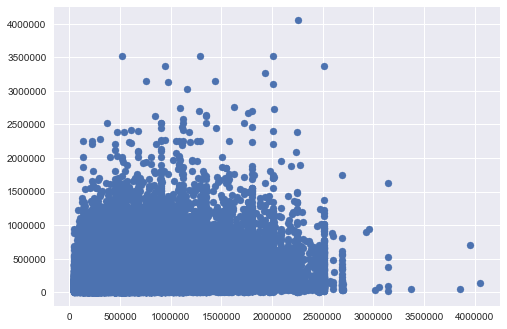

In [87]:
plt.scatter(data["AMT_CREDIT_x"], data["AMT_CREDIT_y"])
plt.show()

In [97]:
a = cowork_cnt(raw_features.index("AMT_ANNUITY"), all_pairs_df, raw_features)
b = cowork_cnt(raw_features.index("AMT_CREDIT_x"), all_pairs_df, raw_features)

## lightgbm

In [157]:
X_num_train = data_train[raw_features].values
X_num_val = data_val[raw_features].values

X_num_train[np.isnan(X_num_train)] = 0
X_num_val[np.isnan(X_num_val)] = 0

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lgb_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=rf_params)
lgb_clf.train(X_num_train, y_train)
pred_val = lgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.747024767902527

In [162]:
lgb_clf.clf.__dict__

{'_Booster': <lightgbm.basic.Booster at 0x1cd412b0>,
 '_best_iteration': None,
 '_best_score': defaultdict(dict, {}),
 '_classes': array([0., 1.], dtype=float32),
 '_evals_result': None,
 '_fobj': None,
 '_le': LabelEncoder(),
 '_n_classes': 2,
 '_n_features': 372,
 '_objective': 'binary',
 '_other_params': {'bagging_seed': 0, 'feature_fraction_seed': 0},
 'bagging_seed': 0,
 'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'feature_fraction_seed': 0,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [164]:
lgb_clf.clf._Booster.__dict__

{'_Booster__attr': {},
 '_Booster__higher_better_inner_eval': [False],
 '_Booster__init_predictor': None,
 '_Booster__inner_predict_buffer': [],
 '_Booster__is_predicted_cur_iter': [],
 '_Booster__name_inner_eval': ['binary_logloss'],
 '_Booster__need_reload_eval_info': False,
 '_Booster__num_class': 1,
 '_Booster__num_dataset': 0,
 '_Booster__num_inner_eval': 1,
 '_Booster__set_objective_to_none': False,
 '_Booster__train_data_name': 'training',
 'best_iteration': 0,
 'best_score': defaultdict(dict, {}),
 'handle': c_void_p(274202432),
 'name_valid_sets': [],
 'network': False,
 'pandas_categorical': None}

In [159]:
help(lgb_clf.clf)

Help on LGBMClassifier in module lightgbm.sklearn object:

class LGBMClassifier(LGBMModel, sklearn.base.ClassifierMixin)
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.ClassifierMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric='logloss', early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbacks=None)
 |      Build a gradient boosting model from the training set (X, y).
 |      
 |      Parameters
 |      ----------
 |      X : array-like or sparse matrix of shape = [n_samples, n_features]
 |          Input feature matrix.
 |      y : array-like of shape = [n_samples]
 |          The target values (class labels in classification, real numbers in regres